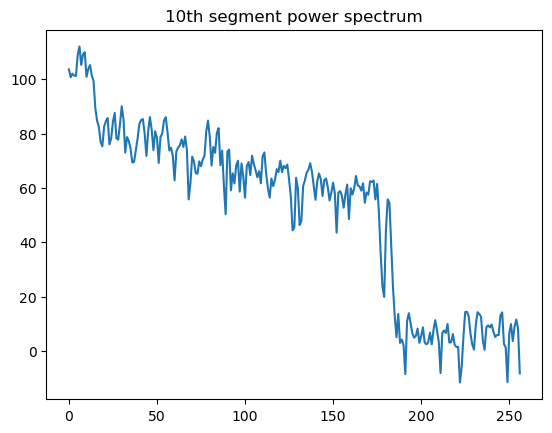

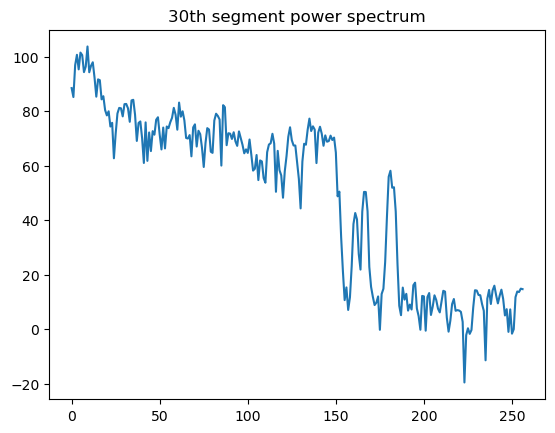

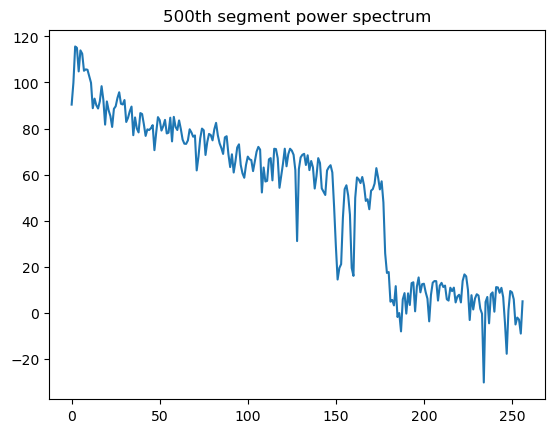

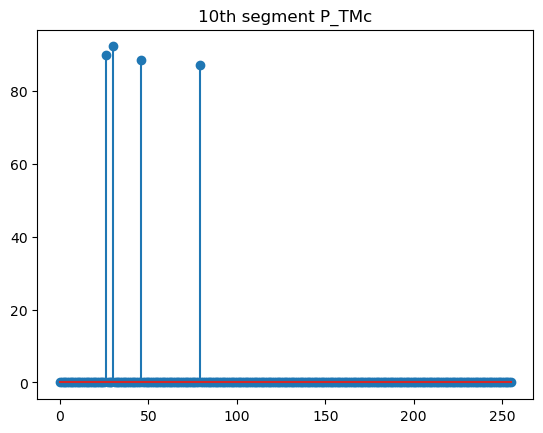

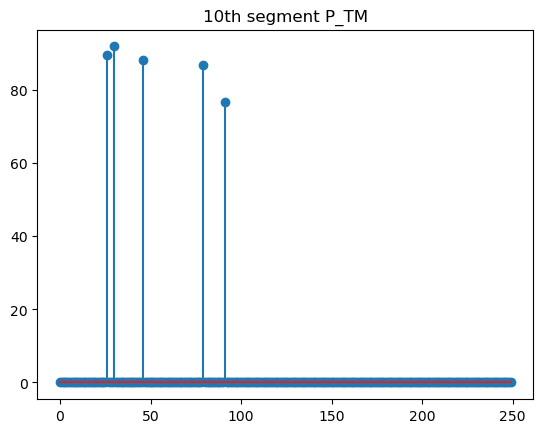

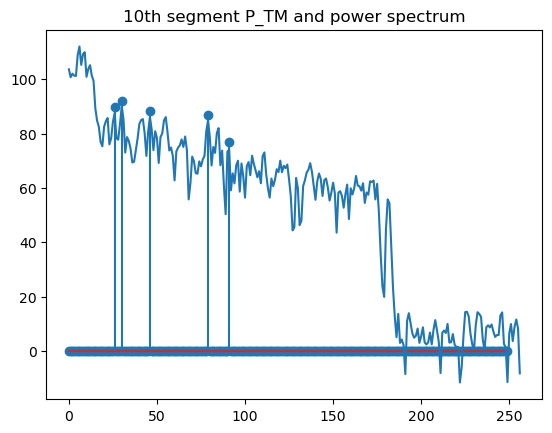

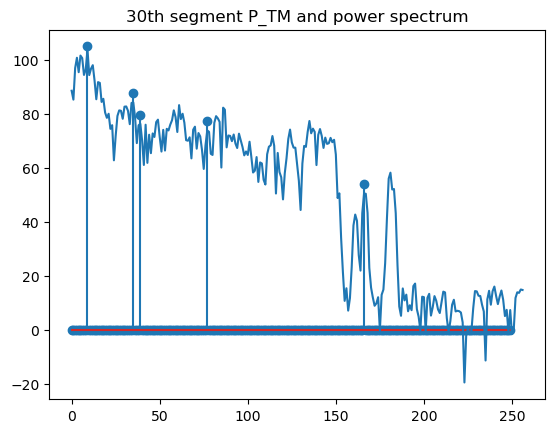

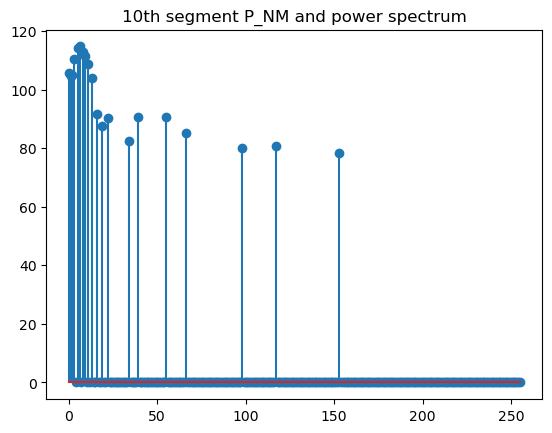

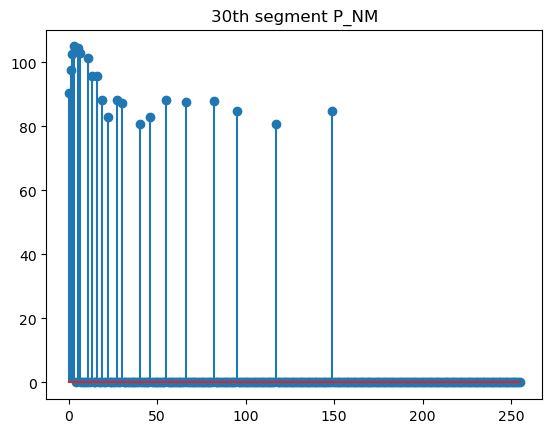

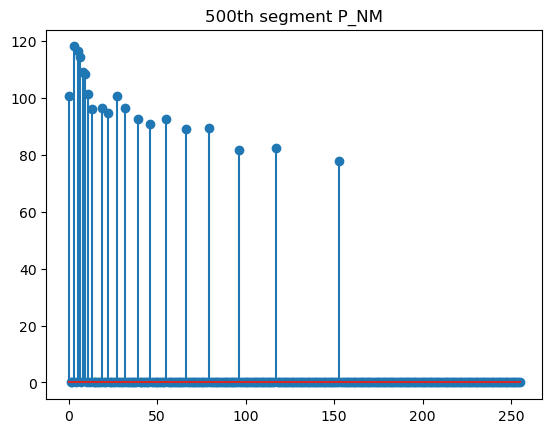

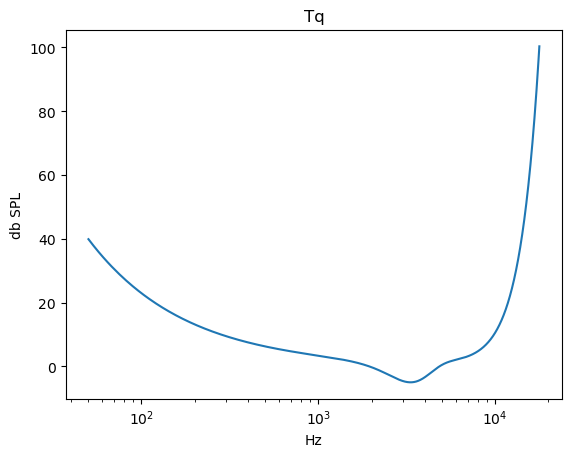

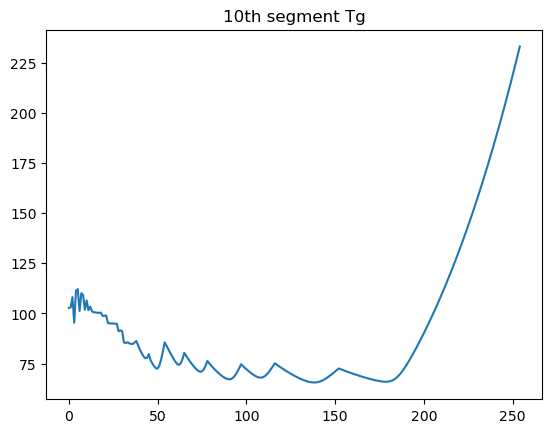

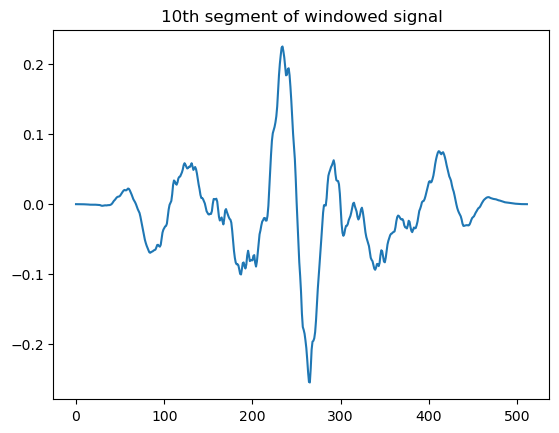

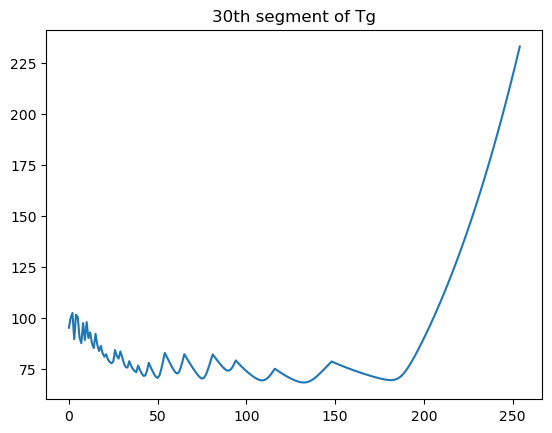

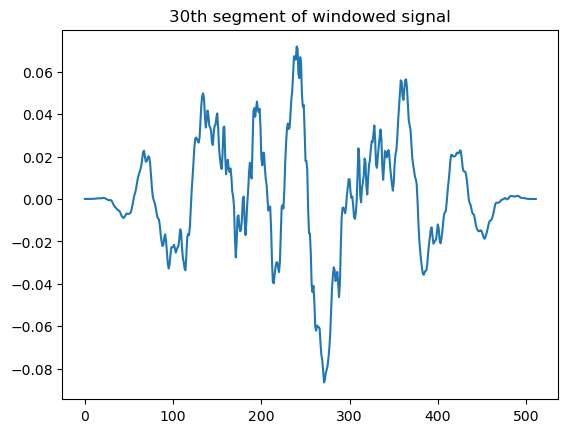

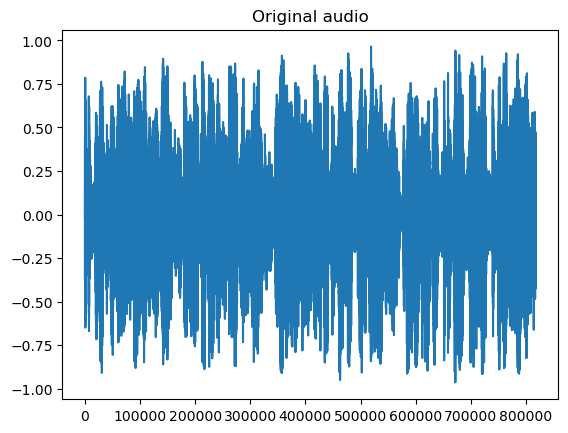

In [1]:
import numpy as np
import matplotlib.pylab as plt
import math
import cmath
import librosa as lib
from numpy.fft import fft, ifft
from scipy.io.wavfile import read, write
from scipy.signal import spectrogram
import random
import os

figure_counter = 0

cwd = os.getcwd()
path= os.path.join(cwd,'music.wav')



# 1.1
def read_from_files(path):
    original, samplerate = lib.load(path, sr=44100)
    return samplerate, original


samplerate, original = read_from_files(path)


def window_signal(original, window, length):
    signal = []
    start = 0
    while start + length < len(original):
        signal.append([original[start + n] * window[n] for n in range(length)])
        start += length
    return signal


def power_spectrum(window_signal, length):
    def calculate_P(signal):
        return 10 * np.log10(abs(fft(signal, n=len(signal))) ** 2) + 90.302

    return [calculate_P(sig)[0:(length // 2) + 1] for sig in window_signal]


def calculate_S_T_k(power_spectrum, length):
    def S_T_k(P, k):
        def D_k(k):
            if 2 < k < 63:
                return [2]
            d_k = []
            if 63 <= k < 127:
                for i in range(2, 4):
                    d_k.append(i)
            if 127 <= k <= 250:
                for i in range(2, 7):
                    d_k.append(i)
            return d_k


        if 3 <= k <= 250:
            d_k = D_k(k)

            bool = True
            for i in range(len(d_k)):
                if not (P[k] > P[k + 1] and P[k] > P[k - 1] and P[k] > (P[k + d_k[i]] + 7) and P[k] > (
                        P[k - d_k[i]] + 7)):
                    bool = False
            return bool
        else:
            return 0

    return [[S_T_k(P, k) for k in range(length // 2 - 6)] for P in power_spectrum]


def calculate_P_TM(power_spectrum, S_T, length):
    P_TM = []
    for i, p in enumerate(power_spectrum):
        temp = []
        for k in range(length // 2 - 6):
            if S_T[i][k] != 0:
                temp.append(10 * np.log10(
                    math.pow(10, (0.1 * p[k - 1])) + math.pow(10, (0.1 * p[k])) + math.pow(10, (0.1 * p[k + 1]))))
            else:
                temp.append(0)
        P_TM.append(temp)
    return P_TM


N = 512
window = np.hanning(N)
window_signal = window_signal(original, window, N)
power_spectrum = power_spectrum(window_signal, N)


figure_counter += 1
plt.figure(figure_counter)
plt.title("10th segment power spectrum")
plt.plot(power_spectrum[10])

figure_counter += 1
plt.figure(figure_counter)
plt.title("30th segment power spectrum")
plt.plot(power_spectrum[30])

figure_counter += 1
plt.figure(figure_counter)
plt.title("500th segment power spectrum")
plt.plot(power_spectrum[500])

S_T = calculate_S_T_k(power_spectrum, N)
P_TM = calculate_P_TM(power_spectrum, S_T, N)

path = os.getcwd()

P_NM = np.load(os.path.join(path, "P_NM-23.npy"))
P_NMc = np.load(os.path.join(path, "P_NMc-23.npy"))
P_TMc = np.load(os.path.join(path, "P_TMc-23.npy"))
P_TMc = np.transpose(P_TMc)
P_NMc = np.transpose(P_NMc)

figure_counter += 1
plt.figure(figure_counter)
plt.title("10th segment P_TMc")
plt.stem((P_TMc[10]))

figure_counter += 1
plt.figure(figure_counter)
plt.title("10th segment P_TM")
plt.stem((P_TM[10]), label="original")


figure_counter += 1
plt.figure(figure_counter)
plt.title("10th segment P_TM and power spectrum")
plt.stem((P_TM[10]), label="original")
plt.plot(power_spectrum[10])

figure_counter += 1
plt.figure(figure_counter)
plt.title("30th segment P_TM and power spectrum")
plt.stem((P_TM[30]), label="original")
plt.plot(power_spectrum[30])


figure_counter += 1
plt.figure(figure_counter)
plt.title("10th segment P_NM and power spectrum")
plt.stem((P_NMc[10]), label="original")

figure_counter += 1
plt.figure(figure_counter)
plt.title("30th segment P_NM")
plt.stem((P_NMc[30]))

figure_counter += 1
plt.figure(figure_counter)
plt.title("500th segment P_NM")
plt.stem((P_NMc[500]), label="original")


def b(i):
    cons = i * samplerate / N
    return 13 * np.arctan(0.00076 * cons) + 3.5 * np.arctan((cons / 7500) ** 2)


def D_b(i, j):
    return b(i) - b(j)


def SF(P_xM, i, j):
    def D_b(i, j):
        return b(i) - b(j)

    D_b = D_b(i, j)

    if -3 <= D_b < -1:
        return 17 * D_b - 0.4 * P_xM[j] + 11
    if -1 <= D_b < 0:
        return (0.4 * P_xM[j] + 6) * D_b
    if 0 <= D_b < 1:
        return -17 * D_b
    if 1 <= D_b < 8:
        return (0.15 * P_xM[j] - 17) * D_b - 0.15 * P_xM[j]

    return "Error"


def T_TM(P_TM, i, j):
    return P_TM[j] - 0.275 * b(j) + SF(P_TM, i, j) - 6.025


def T_NM(P_NM, i, j):
    return P_NM[j] - 0.175 * b(j) + SF(P_NM, i, j) - 2.025


def T_q(i):
    cons = i * samplerate / N
    return 3.64 * ((cons / 1000) ** (-0.8)) - 6.5 * np.exp(-0.6 * (((cons / 1000) - 3.3) ** 2)) + (10 ** (-3)) * (
                cons / 1000) ** 4


T_TM_ = []
T_NM_ = []

counter = 0

for k in range(len(P_TM)):
    temp_t = []
    double_temp_t = []
    for i in range(256):
        temp_t = []
        for j in range(256):
            if P_TMc[k][j] == 0:  # -------------------------------------------------------
                temp_t.append(0)
                continue
            if b(i) < b(j) - 3 or b(i) > b(j) + 8:
                temp_t.append(0)
                continue  # ----------------------------------------------------
            if k == 10:
                counter += 1
            temp_t.append(T_TM(P_TMc[k], i, j))
        double_temp_t.append(temp_t)
    T_TM_.append(double_temp_t)

    double_temp_n = []
    for i in range(256):
        temp_n = []
        for j in range(256):
            if P_NMc[k][j] == 0:  # ----------------------------------------------------
                temp_n.append(0)
                continue
            if b(i) < b(j) - 3 or b(i) > b(j) + 8:
                temp_n.append(0)
                continue  # -------------------------------------------------------
            temp_n.append(T_NM(P_NMc[k], i, j))
        double_temp_n.append(temp_n)
    T_NM_.append(double_temp_n)
    



def T_g(i, T_TM, T_NM, P_TMc, P_NMc):
    sum1, sum2 = 0, 0
    for l in range(len(T_TM[i])):
        if P_TMc[l] != 0:
            sum1 += 10 ** (0.1 * T_TM[i][l])

    for m in range(len(T_NM[i])):
        if P_NMc[m] != 0:
            sum2 += 10 ** (0.1 * T_NM[i][m])

    return 10 * np.log10(10 ** (0.1 * T_q(i)) + sum1 + sum2)


T_g_ = [[T_g(i, T_TM_[k], T_NM_[k], P_TMc[k], P_NMc[k]) for i in range(1, len(P_TMc[k]))] for k in
        range(len(P_TMc) - 1)]

np.save("T_g_i.npy", T_g_)


freqs = np.linspace(10**(1.7), 10**(4.25), 5000)
T_q = [
    3.64 * math.pow(f / 1000, -0.8) - 6.5 * np.exp(-0.6 * math.pow(f / 1000 - 3.3, 2)) + 1 / 1000 * math.pow(f / 1000,
                                                                                                              4) for f
    in freqs]


figure_counter += 1
plt.figure(figure_counter)
plt.xscale('log')
plt.title('Tq')
plt.xlabel('Hz')
plt.ylabel('db SPL')
plt.plot(freqs, T_q)

figure_counter += 1
plt.figure(figure_counter)
plt.title("10th segment Tg")
plt.plot(T_g_[10])

figure_counter += 1
plt.figure(figure_counter)
plt.title("10th segment of windowed signal")
plt.plot(window_signal[10])

figure_counter += 1
plt.figure(figure_counter)
plt.title("30th segment of Tg")
plt.plot(T_g_[30])

figure_counter += 1
plt.figure(figure_counter)
plt.title("30th segment of windowed signal")
plt.plot(window_signal[30])

figure_counter += 1
plt.figure(figure_counter)
plt.plot(original)
plt.title('Original audio')
plt.savefig("original.png")

plt.show()
